In [1]:
import os
from functools import partial

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

from src.utils import load_dataset, extract_all_features, get_image, draw_contours, inference

## Training on full dataset

In [2]:
images_dir = os.environ['PROJECT_DIR'] + '/data/pigments'
target = 'pigment'

In [3]:
# load dataset with extracted features
features_extractor = partial(
    extract_all_features,
    hist=False,
    lbp=False,
    normalize_textural_features=False
)
df = load_dataset(
    images_dir=images_dir,
    target_name=target,
    sample_size=32,
    features_extractor=features_extractor
)

Loading images:   0%|          | 0/176 [00:00<?, ?it/s]

Splitting images:   0%|          | 0/176 [00:00<?, ?it/s]

Features extraction:   0%|          | 0/22749 [00:00<?, ?it/s]

In [4]:
# encode target
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

In [5]:
# train model on entire dataset for inference
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df.drop(target, axis=1), df[target])

RandomForestClassifier(random_state=42)

## Inference

In [6]:
image_path = os.environ['PROJECT_DIR'] + '/data/artworks/portrait.jpg'
image = get_image(image_path)
image = image[300:556, 300:556, :]  # crop the image for faster inference
image, segments, centroids, predictions = inference(image, model, features_extractor)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


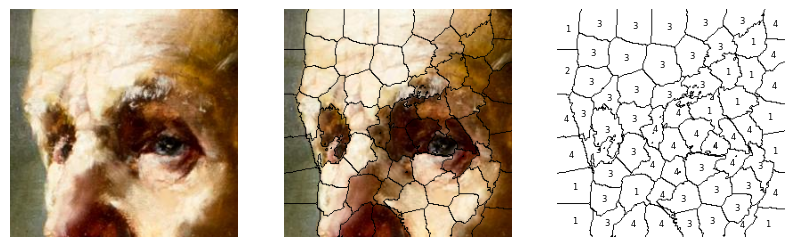

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

# original image
ax[0].imshow(image)
ax[0].axis("off")

# image with detected segments contours
ax[1].imshow(draw_contours(image, segments))
ax[1].axis("off")

# segments contours only
ax[2].imshow(draw_contours(np.ones(image.shape), segments))
ax[2].axis("off")

# make given labels more readable and add numerical labels on the last plot
predictions_mapping = {
    label: (i, label_encoder.inverse_transform([label]).item())
    for i, label in enumerate(np.unique(predictions), start=1)
}
for i, (segment, centroid, label) in enumerate(zip(np.unique(segments), centroids, predictions)):
    ax[2].text(
        *centroid, 
        f'{predictions_mapping[label][0]}', 
        fontsize=6, 
        horizontalalignment='center', 
        verticalalignment='center'
    )
plt.show()

1: [21080] cadmium orange no.0, very I
2: [21120] cadmium red no.1, light
3: [36000] indigo, genuine
4: [44510] cadmium green, dark


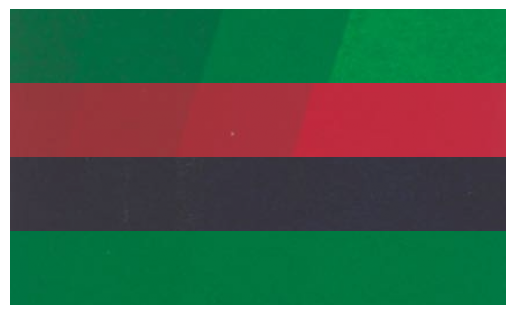

In [8]:
pigments = []
for i, pigment in predictions_mapping.values():
    # read pigment image
    pigment_path = images_dir + '/' + pigment + '.jpg'
    pigment_image = get_image(pigment_path)
    pigments.append(pigment_image)
    print(f'\033[1;31m{i}\033[0;0m: {pigment}')

# cut thin strips of pigments
max_height = 64
max_width = min([p.shape[1] for p in pigments])
pigments = [p[p.shape[0]//2-max_height//2:p.shape[0]//2+max_height//2, :max_width, :] for p in pigments]

plt.imshow(np.concatenate(pigments))
plt.axis('off')
plt.show()